In [68]:
outputfolder  = "plots/"
save_plots    = False
inputfilename = "/Users/Gonzalo/github/NEXTdata/Alphas/run3628.dst"

In [69]:
from __future__ import print_function, division

import os
import sys
import time
import glob

import tables            as tb
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions  as coref
import invisible_cities.core.fit_functions   as fitf
import invisible_cities.reco.peak_functions  as pf
import invisible_cities.reco.pmaps_functions as pf
import invisible_cities.reco.tbl_functions   as tbf
import invisible_cities.reco.dst_functions   as dstf

from invisible_cities.reco.params import Correction

pi = np.pi

print("Running on ", time.asctime())

Running on  Fri Apr 14 13:14:16 2017


In [70]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

In [72]:
def load_z_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "Zcorrections")
    return Correction(dst.z.values, dst.factor.values, dst.uncertainty.values)


def load_xy_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "XYcorrections")
    x    = np.unique (dst.x          .values)
    y    = np.unique (dst.y          .values)
    f    = np.reshape(dst.factor     .values, (len(x), len(y)))
    u    = np.reshape(dst.uncertainty.values, (len(x), len(y)))
    return Correction((x,y), f, u)

def load_t_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "Tcorrections")
    return Correction(dst.t.values, dst.factor.values, dst.uncertainty.values)



In [73]:
corrfilename1 = "/Users/Gonzalo/github/NEXTdata/Kr2016/data/run3389.corr"
corrfilename2 = "/Users/Gonzalo/github/NEXTdata/Alphas/run3628.corr"
zcorr  = load_z_corrections (corrfilename2)
xycorr = load_xy_corrections(corrfilename1)
tcorr  = load_t_corrections (corrfilename2)

In [74]:
dst = dstf.load_dst(inputfilename, "DST", "Events")
dst = dst[:180000]
dst = dst[dst.nS2 == 1]
dst = dst[dst.Z < 530]
print(len(dst))
dst.head()

169041


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.492019e+09,0,1,325.0,343.339508,1969.230554,391325.0,10.200625,3764.766357,...,655137.5,13,263.8125,263.8125,-187.462929,30.724923,189.964130,2.979138,8.080248,8.996847
1,2,1.492019e+09,0,1,350.0,251.357895,1460.681752,552300.0,8.812500,9603.205078,...,654512.5,18,102.2125,102.2125,85.196690,-55.503263,101.681306,-0.577409,8.714130,8.527614
2,3,1.492019e+09,0,1,300.0,248.654160,1424.480923,611050.0,6.043062,17420.824219,...,653562.5,18,42.5125,42.5125,-85.594098,39.492259,94.265520,2.709307,8.428040,8.456854
3,4,1.492019e+09,0,1,300.0,306.161346,1722.519528,474000.0,9.955813,7857.233887,...,655162.5,16,181.1625,181.1625,-142.918068,8.641987,143.179112,3.081198,9.182113,8.241882
4,5,1.492019e+09,0,1,350.0,325.086487,1965.504873,321875.0,10.871688,4010.353027,...,655487.5,11,333.6125,333.6125,2.453711,-124.440975,124.465164,-1.551081,8.089127,7.935277


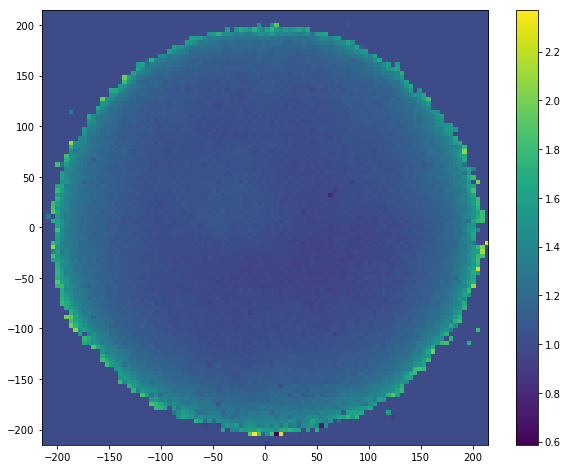

In [75]:
x, y = xycorr.xs.T
x = np.repeat(x, x.size)
y = np.tile  (y, y.size)
plt.hist2d(x, y, (100,100), range=((-215,215), (-215,215)), weights=xycorr.fs.flatten())
plt.colorbar()

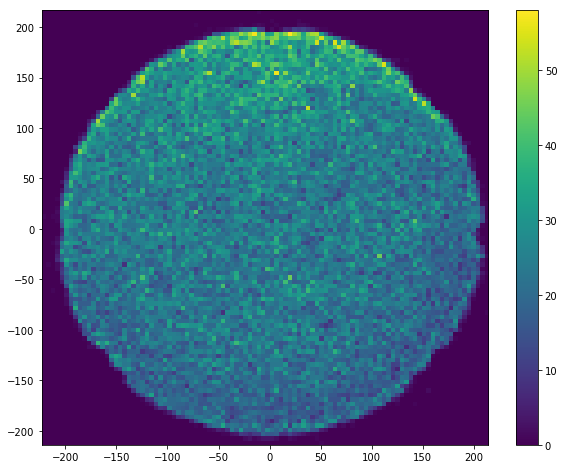

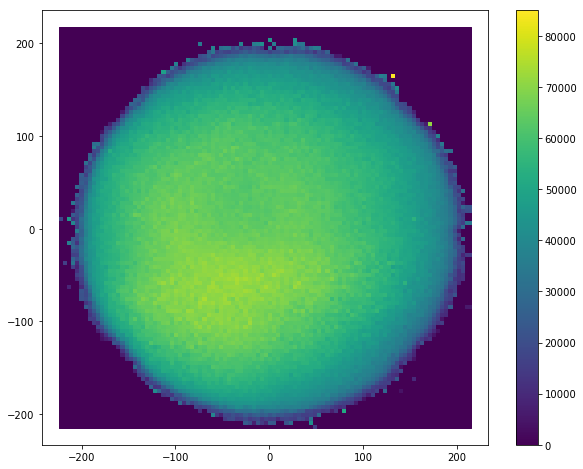

In [76]:
plt.hist2d(dst.X.values, dst.Y.values, (100, 100))
plt.colorbar()
pf, _, _ = profile_and_scatter(dst.X.values, dst.Y.values, dst.S2e.values * zcorr(dst.Z.values)[0], (100, 100))

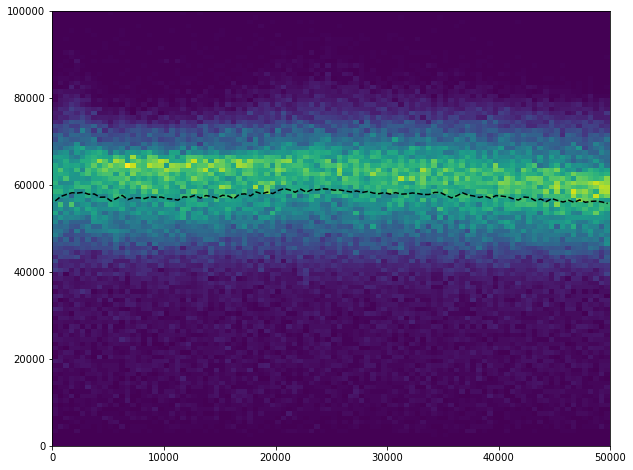

In [77]:
T = dst.time - np.min(dst.time)
E = dst.S2e * zcorr(dst.Z.values)[0] * xycorr(dst.X.values, dst.Y.values)[0]
plt.hist2d(T, E, (100, 100), ((0, np.max(T)),(0, 1e5)))
x, y, _ = fitf.profileX(T, E, 100)
plt.plot(x, y, "k--")
#_x, _y = x, y
#tcorr = lambda t: np.max(y)/_y[np.argmin(t-_x[np.newaxis].T)]
print()

F0: [  1.60130949e+08   1.96704437e+04   7.56319367e+03]
F1: [  1.75104858e+08   6.02346561e+04   8.05065022e+03]
F2: [  2.09745299e+08   6.12772823e+04   7.88827981e+03]
F3: [  2.06286537e+08   6.29120794e+04   7.85748279e+03]


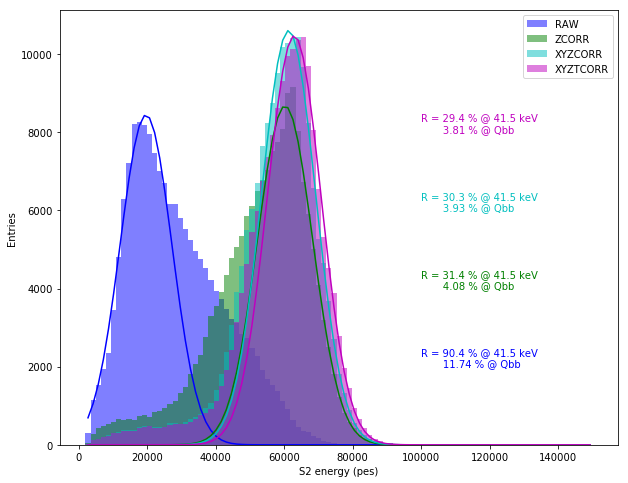

In [80]:
bins = np.linspace(2e3, 150e3, 100)
E = np.array(dst.S2e.values)
plt.figure()
y0, x0, _ = plt.hist(E, bins, label="RAW", alpha=0.5, color="b"); x0 = x0[:-1] + np.diff(x0) * 0.5

E *= zcorr(dst.Z.values)[0]
y1, x1, _ = plt.hist(E, bins, label="ZCORR", alpha=0.5, color="g"); x1 = x1[:-1] + np.diff(x1) * 0.5

E *= xycorr(dst.X.values, dst.Y.values)[0]
y2, x2, _ = plt.hist(E, bins, label="XYZCORR", alpha=0.5, color="c"); x2 = x2[:-1] + np.diff(x2) * 0.5

E *= tcorr(dst.time.values)[0]
y3, x3, _ = plt.hist(E, bins, label="XYZTCORR", alpha=0.5, color="m"); x3 = x3[:-1] + np.diff(x3) * 0.5

m0, m1, m2, m3 = x0[np.argmax(y0)], x1[np.argmax(y1)], x2[np.argmax(y2)], x3[np.argmax(y3)]
f0 = fitf.fit(fitf.gauss, x0, y0, (1e8, m0, 3000), fit_range=(m0 - 10000, m0 + 10000))
f1 = fitf.fit(fitf.gauss, x1, y1, (1e8, m1, 3000), fit_range=(m1 - 10000, m1 + 10000))
f2 = fitf.fit(fitf.gauss, x2, y2, (1e8, m2, 3000), fit_range=(m2 - 10000, m2 + 10000))
f3 = fitf.fit(fitf.gauss, x3, y3, (1e8, m3, 3000), fit_range=(m3 - 10000, m3 + 10000))

plt.plot(x0, f0.fn(x0), "b-")
plt.plot(x1, f1.fn(x1), "g-")
plt.plot(x2, f2.fn(x3), "c-")
plt.plot(x3, f3.fn(x3), "m-")

r0, r1, r2, r3 = 235 * f0.values[2]/f0.values[1], 235 * f1.values[2]/f1.values[1], 235 * f2.values[2]/f2.values[1], 235 * f3.values[2]/f3.values[1]
plt.text(10e4, 2e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r0, r0 * (41.5/2458)**0.5), color="b")
plt.text(10e4, 4e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r1, r1 * (41.5/2458)**0.5), color="g")
plt.text(10e4, 6e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (41.5/2458)**0.5), color="c")
plt.text(10e4, 8e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r3, r3 * (41.5/2458)**0.5), color="m")

plt.legend()

plt.xlabel("S2 energy (pes)")
plt.ylabel("Entries")

print("F0:", f0.values)
print("F1:", f1.values)
print("F2:", f2.values)
print("F3:", f3.values)